In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
#from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer, Vars, reset, trackerreset, datareset
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
#from lowEBMs.Packages.Variables import 
#from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs.Packages.Optimization import coremodule
import lowEBMs.Packages.Constants as const
from lowEBMs import update_plotstyle, moving_average
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [2]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')

In [3]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [ ]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
#labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func3','f'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
#P0=np.array([50*4.2e6,0.5,1.9e-15,0,1.165,1.165,1.165])
#Pmin=np.array([0.5*10*4.2e6,0.4,0.6e-15,-50,0.9,0.9,0.9])
#Pmax=np.array([100*4.2e6,0.6,5e-15,50,1.2,1.2,1.2])
#P_pert_ralative=[1/10000,1/10000,1/10000,1/10000,1/10000,1/10000]
labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
P0=np.zeros(18)
Pmax=np.full(18,50)
Pmin=np.full(18,-50)
#print(Pmax)
P_pert_ratio=1/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-6
maxlength=int(100)
targetmode='Coupled'
target={'GMT':EVA_GMT_1808_1858,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.33
num_params=18
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini')
#print(config_CTRL)
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_Offset.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[2457.7766902  2457.78386034 2457.76952008 2457.79803015 2457.75535034
 2457.80993035 2457.74345028 2457.82149837 2457.73188242 2457.83184753
 2457.72153343 2457.84031664 2457.71306449 2457.84691873 2457.70646259
 2457.85144713 2457.70193434 2457.85372051 2457.69966105 2457.85367647
 2457.69970509 2457.85130046 2457.70208103 2457.84645385 2457.70692748
 2457.839374   2457.71400712 2457.83004129 2457.72333965 2457.81925926
 2457.73412151 2457.80735657 2457.74602405 2457.79482456 2457.75855592
 2457.78256246 2457.77081796]
1e-08
[-0.0001434  -0.0004268  -0.0006648  -0.00089616 -0.00110314 -0.00127252
 -0.00140456 -0.00149513 -0.00154059 -0.00153971 -0.00149219 -0.00139526
 -0.00125367 -0.00106702 -0.00085138 -0.00061333 -0.00036269 -0.00011745]
Iteration no.1


[2457.66985955 2457.67702961 2457.6626895  2457.69119924 2457.64851996
 2457.70309922 2457.63662012 2457.71466701 2457.62505248 2457.72501593
 2457.61470372 2457.73348483 2457.606235   2457.74008676 2457.59963326
 2457.74461506 2457.59510512 2457.74688838 2457.59283188 2457.74684435
 2457.59287592 2457.74446838 2457.59525181 2457.73962187 2457.60009816
 2457.7325422  2457.60717762 2457.72320973 2457.61650991 2457.71242793
 2457.62729154 2457.70052547 2457.63919385 2457.68799367 2457.65172552
 2457.67573174 2457.66398738]
0.0005450982814083284
[ -7.81691429 -23.26482968 -36.23831121 -48.84962017 -50.
 -50.         -50.         -50.         -50.         -50.
 -50.         -50.         -50.         -50.         -46.4085541
 -33.43237594 -19.77006798  -6.40194569]
Iteration no.2


[535.47868023 535.46646286 535.4908982  535.44773962 535.50962464
 535.43644415 535.52092322 535.42939466 535.52797499 535.4274624
 535.52990772 535.42981557 535.52755344 535.43036867 535.52700018
 535.42933649 535.52803281 535.42848338 535.52888624 535.42874592
 535.52862362 535.43009764 535.52727141 535.43151245 535.5258561
 535.43117226 535.52619654 535.42725577 535.53011495 535.43048471
 535.52688523 535.43890098 535.51846609 535.45161885 535.50574473
 535.46869068 535.4886702 ]
0.0002189020063980095
[ -2.46796954  -9.71807525 -17.74567336 -27.27018931 -27.57451263
 -28.60498413 -28.84716933 -28.39517569 -28.02161263 -28.13657086
 -28.72846559 -29.34798479 -29.19899535 -27.48391989 -25.30628727
 -16.01541399  -7.92180572  -2.02838843]
Iteration no.3


[628.33917084 628.34425973 628.33408862 628.35373495 628.324625
 628.36079815 628.31756223 628.36590913 628.31244161 628.37003122
 628.30833474 628.37286326 628.30550293 628.37521869 628.30317757
 628.3770405  628.30136602 628.37797915 628.30040668 628.37787293
 628.3005229  628.37666099 628.30172473 628.37421293 628.3041968
 628.37068033 628.30770505 628.3658482  628.31249758 628.36003742
 628.3183138  628.35325739 628.32508362 628.34843505 628.32993447
 628.34238188 628.33597793]
0.00013331795324099865
[ -3.82396096 -13.59895485 -23.50979699 -34.39836943 -35.79976085
 -37.58532532 -38.45154303 -38.48394318 -38.36341594 -38.44871872
 -38.71881356 -38.6823913  -37.59473116 -34.59651547 -30.8687956
 -19.77148408 -10.38826525  -2.88215042]
Iteration no.4


[296.27684916 296.27689029 296.27662449 296.27749459 296.27604415
 296.27746414 296.27627316 296.27654855 296.27696501 296.2823218
 296.27125153 296.28692505 296.26657616 296.29004738 296.26351082
 296.29160212 296.26185333 296.29231641 296.26113805 296.29246356
 296.26104691 296.29196403 296.2615666  296.29112429 296.26239559
 296.29021165 296.26335538 296.2887506  296.26475869 296.2862242
 296.26716851 296.28480184 296.26875118 296.28185751 296.27175872
 296.27842037 296.2751973 ]
0.000196367650634335
[ -3.87615648 -13.88377561 -23.74366648 -34.31659089 -37.9736028
 -41.58118836 -43.66246562 -44.32564387 -44.48583703 -44.61793155
 -44.68788452 -44.32377924 -42.86843438 -39.3077516  -34.61071637
 -22.92331402 -12.37133914  -3.5150565 ]
Iteration no.5


[225.36658901 225.36980066 225.36337747 225.37507626 225.35810244
 225.37820872 225.35497058 225.38025828 225.35292151 225.38071454
 225.35246539 225.38039663 225.35278342 225.3803492  225.35283107
 225.38063231 225.35254821 225.38083394 225.35234672 225.38074016
 225.35244049 225.38035294 225.35282756 225.37993651 225.35324372
 225.38015288 225.3530271  225.38106182 225.35211811 225.38075024
 225.35242951 225.3785157  225.3546635  225.37457934 225.35859921
 225.36946322 225.36371488]
4.807578055127737e-05
[ -4.18495634 -14.69980551 -24.86085818 -35.63082716 -39.33170259
 -42.90871526 -44.98542137 -45.67580914 -45.85538213 -45.9784603
 -46.01118834 -45.60705572 -44.17252777 -40.69924304 -35.97225767
 -24.0700272  -13.13959648  -3.79141227]
Iteration no.6


[202.29575058 202.29828431 202.29321695 202.30240674 202.28909515
 202.30470484 202.2867977  202.30614934 202.2853537  202.30631998
 202.2851832  202.30580358 202.28569971 202.30556183 202.28594168
 202.30566579 202.28583797 202.30576675 202.28573715 202.305685
 202.2858189  202.30542024 202.2860835  202.30520314 202.28630032
 202.30562761 202.28587561 202.30669287 202.28481032 202.30670844
 202.28479456 202.30512953 202.28637289 202.30208518 202.28941654
 202.2980387  202.29346252]
0.00017989415679010387
[ -5.09654462 -17.0944842  -28.08224877 -39.37184114 -43.13408517
 -46.52528473 -48.51497131 -49.2427177  -49.45859011 -49.5522553
 -49.48975395 -49.00756305 -47.72579654 -44.63578555 -39.91443638
 -27.44423678 -15.41861109  -4.61464082]
Iteration no.7


[258.53798655 258.5372001  258.5387732  258.53603358 258.53994079
 258.53499308 258.54098231 258.53423856 258.54173759 258.53368751
 258.5422888  258.53279943 258.54317698 258.5320404  258.5439363
 258.5315258  258.54445126 258.5312526  258.54472468 258.5312225
 258.54475477 258.53141852 258.54455853 258.53177644 258.54420033
 258.53239582 258.54358094 258.53292326 258.54305416 258.53387611
 258.54210087 258.53497394 258.54100184 258.53601109 258.53996324
 258.53726198 258.53871129]
0.0001185650447896836
[ -4.91002973 -16.63122557 -27.37213584 -38.48271777 -42.11427391
 -45.29487005 -47.10453383 -47.7102104  -47.86127308 -47.94780117
 -47.93180749 -47.53452408 -46.39963294 -43.43461589 -38.93926784
 -26.72953791 -14.95002502  -4.44280287]
Iteration no.8


[188.31256678 188.31071025 188.31444007 188.3082656  188.31678552
 188.3065582  188.31844867 188.30518633 188.32000746 188.30407686
 188.32088072 188.30250443 188.32231954 188.30071177 188.32396126
 188.29983741 188.32540016 188.2993874  188.32613855 188.29917092
 188.32635563 188.29946491 188.32614864 188.29877337 188.32675058
 188.2958208  188.3293215  188.28888656 188.33634082 188.29362919
 188.33205255 188.29831326 188.32707942 188.30306138 188.32150081
 188.30904533 188.31574385]
5.780846124265114e-05
[ -4.69441481 -16.13870235 -26.68476597 -37.62593088 -41.14286844
 -44.1493892  -45.76051606 -46.23246757 -46.31483037 -46.37629497
 -46.38926237 -45.91720425 -44.46300907 -40.69135802 -36.71807273
 -25.06661057 -13.88407037  -4.0555715 ]
Iteration no.9


[190.48974332 190.49175281 190.48773394 190.49500211 190.48448532
 190.49670847 190.48277964 190.49775959 190.48172904 190.49780319
 190.48168557 190.49724483 190.48224403 190.4969448  190.48254428
 190.4969643  190.48252503 190.49701267 190.48247681 190.49694452
 190.48254494 190.4967592  190.48273011 190.49666784 190.48282119
 190.4972112  190.48227758 190.49834316 190.4811456  190.49854465
 190.48094392 190.49738239 190.48210559 190.49493077 190.48455647
 190.49161978 190.48786693]
3.7400333133121757e-05
[ -4.84472159 -16.53203358 -27.20570872 -38.22547866 -41.74567273
 -44.71042379 -46.29910037 -46.77250136 -46.85847614 -46.91484404
 -46.91395509 -46.43507366 -45.02153132 -41.3345522  -37.37634577
 -25.63796782 -14.27207265  -4.19592953]
Iteration no.10


[184.70805215 184.70972629 184.70637814 184.71241409 184.70369106
 184.71372843 184.70237742 184.71450367 184.70160271 184.71442949
 184.70167701 184.71379617 184.70231043 184.71341782 184.70268899
 184.71335929 184.70274778 184.71336279 184.70274443 184.7133009
 184.70280631 184.71317186 184.70293518 184.71316881 184.70293795
 184.71379677 184.70230974 184.71498032 184.70112619 184.71532119
 184.70078512 184.71446181 184.70164389 184.71243431 184.70367064
 184.7096418  184.7064626 ]
0.00016552314083964064
[ -5.39891888 -17.97589695 -29.08456456 -40.36088628 -43.85650359
 -46.61158035 -48.07496966 -48.52895156 -48.6160603  -48.65194099
 -48.60836166 -48.12851784 -46.92290108 -43.627731   -39.78240179
 -27.75963043 -15.7226621   -4.72216031]
Iteration no.11


[246.12126272 246.10925028 246.13327597 246.0926485  246.15014731
 246.08287504 246.15983674 246.07592772 246.16678725 246.07246048
 246.1702557  246.06844061 246.17427665 246.06360573 246.17911353
 246.05932236 246.18339908 246.0567566  246.18596614 246.05621245
 246.18651054 246.05738418 246.18533802 246.05446562 246.18825785
 246.04073034 246.20200115 246.00960571 246.23297439 246.02533465
 246.21723353 246.04668136 246.19604776 246.07286651 246.16984747
 246.10370183 246.13882491]
1.2915301794922666e-05
[ -5.08861986 -17.23328247 -28.09058109 -39.18740806 -42.59344881
 -45.24467595 -46.58315146 -46.92646335 -46.94728005 -46.96910187
 -46.95579918 -46.40055085 -44.84003991 -40.74285698 -37.30396981
 -25.83051825 -14.47012363  -4.26853507]
Iteration no.12


[182.43136962 182.43297525 182.42975095 182.43558672 182.42715653
 182.43668885 182.42604411 182.43758978 182.42535016 182.43742134
 182.42552    182.43691195 182.42601708 182.43643536 182.42630586
 182.43626912 182.42628421 182.43620515 182.42634956 182.43634075
 182.42641833 182.43605521 182.42649906 182.43621694 182.42654291
 182.43712329 182.42563217 182.43893849 182.42444291 182.43890552
 182.42386341 182.43807386 182.42467802 182.43584487 182.42689158
 182.43301273 182.42991814]
1.1924952799041121e-05
[ -5.12706953 -17.33381205 -28.21751912 -39.33336497 -42.73537169
 -45.37459681 -46.7039452  -47.04553297 -47.0648075  -47.08742633
 -47.06975583 -46.51591317 -44.97707101 -40.91571613 -37.48334619
 -25.99026308 -14.57689117  -4.30543795]
Iteration no.13


[181.71288752 181.71378473 181.71201371 181.71520394 181.71059691
 181.71566107 181.71004793 181.71621988 181.70977205 181.7159009
 181.71009177 181.71505249 181.71094092 181.71438845 181.71160603
 181.71404835 181.71194718 181.7138795  181.71211666 181.71400232
 181.71201719 181.71376464 181.71223123 181.71382417 181.71198503
 181.71398745 181.71182718 181.71353247 181.7124842  181.71492349
 181.7110857  181.71520824 181.71060406 181.71447699 181.71151436
 181.71359177 181.71220707]
1.6295294826082194e-05
[ -5.15592891 -17.40888507 -28.30898686 -39.43843429 -42.83003319
 -45.44159611 -46.74928565 -47.07977209 -47.0935336  -47.11977459
 -47.09474331 -46.54588251 -45.01227313 -40.93279812 -37.54588407
 -26.06528949 -14.62516805  -4.32800192]
Iteration no.14


[181.56098979 181.56169886 181.56028135 181.56298265 181.55919851
 181.56340619 181.55878986 181.56349244 181.55849311 181.56313128
 181.55864285 181.56224367 181.5595312  181.56171497 181.56006095
 181.56151227 181.5602648  181.56131377 181.56046421 181.56122115
 181.56055698 181.56121076 181.56056687 181.56103216 181.5607462
 181.56064464 181.56113806 181.56044518 181.56177456 181.5612175
 181.56057122 181.56195054 181.55983017 181.56178111 181.55999169
 181.56126283 181.56071767]
2.8977373681544286e-05
[ -5.19700438 -17.51853934 -28.44275594 -39.58330195 -42.96009609
 -45.5201962  -46.79721466 -47.11592039 -47.11815149 -47.13902061
 -47.11340134 -46.55416883 -44.99797513 -40.89427611 -37.56461174
 -26.12673234 -14.67702078  -4.34379912]
Iteration no.15


[181.42798918 181.42856575 181.42759835 181.42936329 181.42643153
 181.42993808 181.42612268 181.43016043 181.42600869 181.42998208
 181.426401   181.42906854 181.42722286 181.42831794 181.42788202
 181.42789302 181.42830823 181.42785766 181.42852968 181.42776189
 181.42862558 181.42767228 181.42862209 181.42756783 181.42881983
 181.42706985 181.42913676 181.42599949 181.43022001 181.42770161
 181.42869661 181.42844602 181.42794371 181.42871128 181.42767051
 181.42809298 181.42807125]
2.3067308352187664e-05
[ -5.21931965 -17.58616732 -28.53076695 -39.67907152 -43.04270187
 -45.5627711  -46.80727002 -47.10634256 -47.10264977 -47.11909759
 -47.09149177 -46.52528849 -44.95029725 -40.79692003 -37.54165987
 -26.13831929 -14.70102852  -4.34430031]
Iteration no.16


[181.33156907 181.3321483  181.33096278 181.33294783 181.32979385
 181.33352473 181.32959032 181.33353731 181.32957942 181.33315155
 181.32996584 181.33224641 181.33087163 181.33150374 181.33142982
 181.33117671 181.3318507  181.33105153 181.33206935 181.33095672
 181.33216426 181.33095935 181.33216122 181.33076602 181.33235502
 181.33070801 181.33265747 181.32966786 181.33328529 181.33135638
 181.33177491 181.33208237 181.33146649 181.33190157 181.33121443
 181.3316859  181.33142547]
4.8521368847703396e-05
[ -5.27684261 -17.73920278 -28.72166998 -39.87111374 -43.19727648
 -45.62947706 -46.8108565  -47.07363989 -47.0532637  -47.06050616
 -47.03317553 -46.44818785 -44.85570665 -40.62139715 -37.52135221
 -26.16820252 -14.73436969  -4.35693689]
Iteration no.17


[181.140274   181.14077138 181.13977686 181.14177079 181.1387793
 181.14238608 181.13837978 181.14241122 181.13835633 181.14204055
 181.13872765 181.14115576 181.13939997 181.14052573 181.13991101
 181.14021233 181.14013292 181.14000142 181.14034467 181.13990875
 181.14043748 181.13990944 181.14043631 181.13972371 181.1406227
 181.13927039 181.14107998 181.13891072 181.14187944 181.13995227
 181.14040475 181.14063191 181.13971656 181.1408226  181.13973103
 181.14033113 181.14021723]
6.896464148582666e-05
[ -5.34542899 -17.94550945 -28.9979631  -40.15075756 -43.42574971
 -45.75056427 -46.85325053 -47.0791161  -47.02959165 -47.02404253
 -46.9968402  -46.38618915 -44.73090868 -40.41666081 -37.49014716
 -26.23132932 -14.80964969  -4.36479171]
Iteration no.18


[180.88741199 180.88836235 180.88707579 180.88907355 180.88599556
 180.8894164  180.8858407  180.88959293 180.88585177 180.88921858
 180.88604094 180.8883381  180.88692226 180.88761288 180.88764867
 180.88719791 180.88806481 180.88698072 180.88828271 180.88688836
 180.88837518 180.88689539 180.88836773 180.88670714 180.88855645
 180.88640755 180.88846014 180.88556689 180.88971419 180.88726523
 180.88819488 180.88780164 180.88706393 180.88808561 180.88717259
 180.88792371 180.88732904]
1.9221431895715407e-05
[ -5.37015856 -18.0046728  -29.06669322 -40.2226679  -43.48682863
 -45.77777874 -46.85256263 -47.06245295 -47.00456548 -46.99546379
 -46.96853981 -46.35064276 -44.69145497 -40.33694374 -37.47227801
 -26.24550908 -14.82719937  -4.37622209]
Iteration no.19


[180.8119016  180.81225457 180.81102865 180.81336118 180.81020445
 180.81353232 180.8100354  180.81372126 180.80966164 180.81335615
 180.81002758 180.81248687 180.81089768 180.81177335 180.8116124
 180.81136728 180.81201963 180.81115508 180.81223254 180.81106394
 180.81232379 180.81106899 180.81231832 180.8108857  180.81250209
 180.81100972 180.81278201 180.80982158 180.81358374 180.81130703
 180.811905   180.81239191 180.81139772 180.81223085 180.81115156
 180.81201522 180.81136171]
4.055251176580671e-05
[ -5.41987266 -18.13268617 -29.20850195 -40.3872959  -43.62181045
 -45.84222454 -46.8590895  -47.03599857 -46.96087187 -46.9443738
 -46.91787634 -46.28509389 -44.61958403 -40.18437867 -37.44802915
 -26.28582594 -14.8709673   -4.40272356]
Iteration no.20


[180.65723376 180.65777802 180.65669013 180.65870299 180.65586024
 180.65930601 180.65559324 180.65931659 180.65537075 180.65896283
 180.65572524 180.65810936 180.65657946 180.65759726 180.65709257
 180.65738752 180.65730345 180.65718047 180.6575114  180.65709099
 180.65760104 180.65709482 180.65759671 180.65691714 180.65777512
 180.65647672 180.65821991 180.65573564 180.65918693 180.65698263
 180.65772003 180.65784992 180.65684471 180.65786534 180.65682137
 180.65736897 180.65709948]
8.44401721057887e-05
[ -5.51173417 -18.37272845 -29.52200885 -40.720483   -43.89519309
 -45.97140943 -46.90170597 -47.04309728 -46.93292777 -46.90130488
 -46.87549679 -46.21264582 -44.4723887  -39.89295123 -37.38576299
 -26.37070644 -14.95911991  -4.42547908]
Iteration no.21


[180.36825924 180.36865376 180.36786494 180.36949188 180.36684197
 180.3698049  180.36628997 180.36978845 180.36630829 180.36943667
 180.36666081 180.36880885 180.36750364 180.36811572 180.36810462
 180.36790391 180.3684114  180.36769395 180.36862219 180.36760568
 180.36871061 180.36761468 180.36870113 180.36743884 180.36887762
 180.36698413 180.36933631 180.36617398 180.36994545 180.36766063
 180.36866648 180.36838535 180.3679332  180.36864841 180.36766192
 180.3682559  180.36826293]
6.204125816653803e-05
[ -5.56067356 -18.5371321  -29.7400794  -40.93639688 -44.06741069
 -46.05238667 -46.90239516 -47.01161189 -46.87533856 -46.83275392
 -46.80809256 -46.12338237 -44.32645634 -39.65896435 -37.32335869
 -26.39875841 -15.02032344  -4.42504251]
Iteration no.22


[180.16412059 180.16484278 180.16377473 180.16577085 180.16287448
 180.16612314 180.16271201 180.16614006 180.16269661 180.16581416
 180.16280943 180.1650039  180.16340662 180.16434401 180.16369188
 180.16415832 180.16406669 180.16415036 180.16426326 180.16406569
 180.16434809 180.16406927 180.164344   180.16390886 180.16450516
 180.16352372 180.16489466 180.1631099  180.16556151 180.16409094
 180.16433352 180.16489558 180.1635208  180.1648407  180.16356771
 180.16448339 180.1641344 ]
7.656379318079294e-05
[ -5.64244767 -18.75888916 -30.00124878 -41.20004049 -44.29746375
 -46.1746805  -46.95232504 -47.01862772 -46.86669496 -46.81113235
 -46.78705881 -46.07772754 -44.22149178 -39.47125947 -37.30478562
 -26.50401709 -15.11778848  -4.45176226]
Iteration no.23


[179.94848709 179.94872493 179.94763314 179.94965238 179.9470834
 179.94972402 179.94663971 179.94968224 179.94668337 179.94952887
 179.94702491 179.94871182 179.94784278 179.94803581 179.94851999
 179.94764084 179.94891613 179.94743099 179.94912669 179.9473452
 179.94921259 179.94735929 179.94919808 179.94718844 179.94927583
 179.94731933 179.9496448  179.94611429 179.95046144 179.94761385
 179.94876753 179.94844852 179.94821882 179.94865238 179.94790004
 179.94835102 179.9480075 ]
4.456415822435842e-06
[ -5.64731314 -18.77033762 -30.01499372 -41.21340474 -44.30862247
 -46.17855333 -46.95016731 -47.01294453 -46.85913818 -46.80281049
 -46.77886441 -46.06842526 -44.21112852 -39.45188675 -37.29964433
 -26.50504073 -15.12114122  -4.45329315]
Iteration no.24


[179.93256648 179.93300101 179.93213262 179.93375388 179.93156892
 179.93404818 179.9313039  179.93401256 179.93112637 179.93367534
 179.93124946 179.93286214 179.93206339 179.93237784 179.93254871
 179.93217395 179.93275374 179.93196633 179.93296227 179.93188101
 179.93304775 179.93189402 179.93303422 179.9317253  179.9332037
 179.93127716 179.93365623 179.93047018 179.93466309 179.93177014
 179.93316932 179.93269546 179.93223592 179.93279774 179.93212567
 179.93263192 179.93250199]
1.4059649278667108e-05
[ -5.65952244 -18.80105748 -30.05357729 -41.25398353 -44.3427294
 -46.18978342 -46.94776485 -47.00479293 -46.84513574 -46.78640653
 -46.76283363 -46.04763949 -44.17767956 -39.39293592 -37.27997232
 -26.5115017  -15.13059023  -4.45511993]
Iteration no.25


[179.88977611 179.89023202 179.88950833 179.89125659 179.88853875
 179.89172985 179.88844333 179.89170837 179.88846669 179.8913797
 179.88879609 179.89057615 179.88938585 179.88991533 179.88986013
 179.88972067 179.89024372 179.88951822 179.89044702 179.88943401
 179.89053137 179.88944469 179.89052021 179.88928126 179.89068429
 179.88885891 179.89092283 179.88813765 179.89187123 179.88956886
 179.89040654 179.89026512 179.88970252 179.89050342 179.88945641
 179.88987493 179.88986554]
5.295246739622457e-06
[ -5.66335454 -18.81544914 -30.07098022 -41.27114906 -44.35641028
 -46.19608638 -46.94805714 -47.00202322 -46.84021751 -46.78059574
 -46.75713851 -46.04021014 -44.16675058 -39.37316569 -37.27553658
 -26.51448079 -15.13613438  -4.4551697 ]
Iteration no.26


[179.87391481 179.87418683 179.87321443 179.87516406 179.87242795
 179.87526478 179.87214141 179.87543353 179.87197429 179.87510691
 179.87230174 179.87430588 179.87310358 179.87364768 179.87376298
 179.87326735 179.87414448 179.87306594 179.8743466  179.872982
 179.87443065 179.87299229 179.87441994 179.87282994 179.87458276
 179.87300314 179.87460146 179.87189223 179.87553844 179.87334413
 179.87389171 179.87440677 179.8734102  179.87423287 179.87317442
 179.87402088 179.8733809 ]
4.519472600565782e-06
[ -5.66774926 -18.82781495 -30.0850962  -41.286783   -44.36908818
 -46.20152011 -46.94753603 -46.99805904 -46.83442961 -46.77404857
 -46.75068627 -46.0322883  -44.159527   -39.35668674 -37.27306182
 -26.51898478 -15.14091806  -4.45806206]
Iteration no.27


[179.85925658 179.86014845 179.85898245 179.86075384 179.85800442
 179.86123309 179.85790347 179.86121649 179.85792196 179.86089171
 179.85815361 179.86009295 179.85885932 179.85943707 179.85951639
 179.85905848 179.85989615 179.85885804 179.8600973  179.85877433
 179.86018112 179.85878424 179.86017079 179.85881083 179.86033269
 179.8586127  179.8601593  179.85769961 179.86127414 179.85933401
 179.85982055 179.8597995  179.85894363 179.86001915 179.85893095
 179.85979718 179.8591465 ]
2.0721552943592166e-05
[ -5.69191051 -18.88478721 -30.15409093 -41.35505079 -44.42582583
 -46.22708274 -46.94589234 -46.98070127 -46.80875026 -46.74489788
 -46.72195498 -46.00075291 -44.12747889 -39.28261696 -37.26297989
 -26.5367197  -15.16346731  -4.47154501]
Iteration no.28


[1.00000000e-08 1.77395642e-08 2.85724995e-08 8.58963025e-08
 5.57974862e-06 5.73503531e-06 2.74296859e-07 3.24820793e-06
 3.63209248e-06 5.14230911e-06 8.00278736e-06 8.04019510e-06
 2.84993857e-06 5.27860569e-06 5.02606569e-05 1.45561666e-05
 8.54529249e-06 9.75130014e-06 4.56759146e-05 1.49370232e-04
 1.49400592e-05 6.63090028e-06 6.26359544e-06 3.32585687e-06
 5.38435651e-06 2.16106943e-05 2.76349542e-05 3.03007707e-06
 1.31489353e-05 1.49126351e-06 4.80757125e-06 4.21257448e-06
 8.14336241e-06 1.46034469e-05 1.01760359e-04 2.06391576e-04
 4.84265115e-06 3.77110721e-06 8.79554521e-06 2.69817801e-06
 3.20407860e-06 2.53224150e-06 2.04207217e-06 2.31604431e-06
 9.48218702e-09 4.50756880e-08 2.18737969e-09 2.19782864e-08
 2.62946191e-08 9.21950808e-08 1.43588462e-07 1.78580912e-07
 1.46593788e-07 4.34165261e-08 7.95541623e-08 7.20321922e-08
 6.47044143e-08 2.26633853e-07 5.11105760e-07 5.86262276e-07
 6.52968993e-08 6.96169658e-09 1.37972286e-08 7.84643432e-10
 1.06837034e-05 3.057489

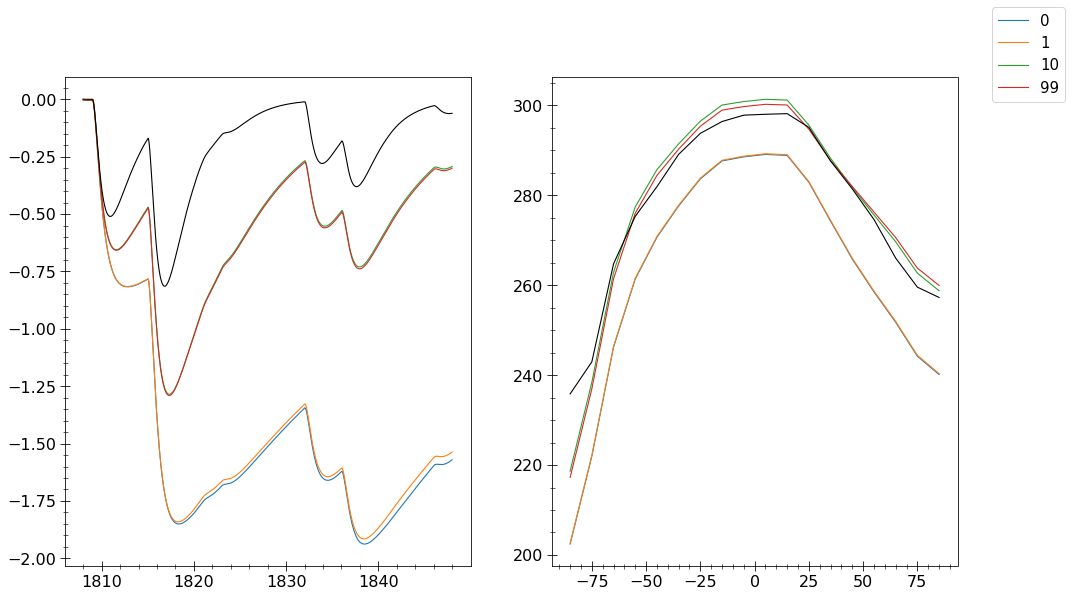

In [6]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
for i in [0,1,10,99]:
    ax[0].plot(Year_volc_1808_1858,data[1][i,0],label=i)
for i in [0,1,10,99]:
    ax[1].plot(Vars.Lat,data[0][i,0]+elevation)
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')
ax[1].plot(Lat_10,ZMT_10,c='k')
plt.figlegend(fontsize=15)
#plt.xlim(1808,1858)
print(gamma)

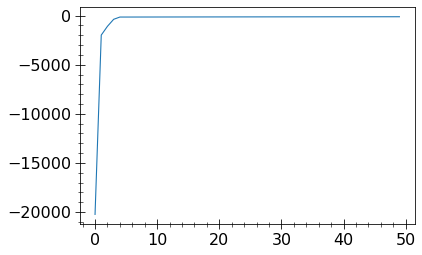

In [13]:
plt.plot(np.arange(50),dF[:,0])

In [31]:
print(gamma)
print(F)
print(dF)
print(P)

[1.00000000e-07 9.99972776e-08 7.96411807e-05 1.25390005e-04
 1.12720129e-04 1.10334142e-04 1.14971662e-04 1.10323682e-03]
[[4908.46279504 4907.68081928 4909.23973105 4895.28385247 4923.48298139
  4823.27040287 5054.43158254 4908.28522758 4908.63776618 4908.43195343
  4908.4941851  4907.80603045 4909.1303077 ]
 [1753.97298698 1753.97300141 1753.97298094 1754.48947943 1753.45663279
  1753.97427467 1753.97169816 1753.9730001  1753.97298007 1753.97303131
  1753.97294266 1753.97350971 1753.97247316]
 [1751.16403766 1751.16404821 1751.16402823 1751.67986844 1750.64831832
  1751.16532353 1751.16274737 1751.16404375 1751.16403319 1751.16407915
  1751.1639929  1751.16454727 1751.16352985]
 [ 276.06893623  276.0685077   276.0693672   276.25742215  275.88053744
   276.07116675  276.06670406  276.07005415  276.06781831  276.06927555
   276.0685969   276.07429964  276.06357283]
 [  90.3567686    90.35446318   90.35907689   90.33866833   90.37496561
    90.35391603   90.35962299   90.35721128   90.

In [18]:
print(70*4.2e6)

294000000.0


In [30]:
print(0.33*np.sum(((data[0][8,0]-target['ZMT'])*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2))
print(0.66*np.sum(((data[1][8,0]-target['GMT']))**2))

38.13576100244077
45.9309035943473


In [35]:
print(np.sqrt(np.dot(dF[-2],dF[-2])))
print(np.sqrt(np.dot(dF[0],dF[0])))

117.79102151319456
7220029.930903146


In [35]:
#setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P=[3.02794273e+08, 4.80868504e-01, 2.47299528e-15, 1.16506701e+00,
 1.16500290e+00, 1.16499030e+00]
#P1=[2.10056979e+08, 5.00042362e-01, 2.01124229e-15, 1.16500050e+00,1.16500009e+00, 1.16500191e+00]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['funccomp'],progressbar=True)
ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base,initialZMT=False)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config=add_parameters(config_base,P,labels)
Vars.T,Vars.T_global=ZMT,GMT   
data1=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


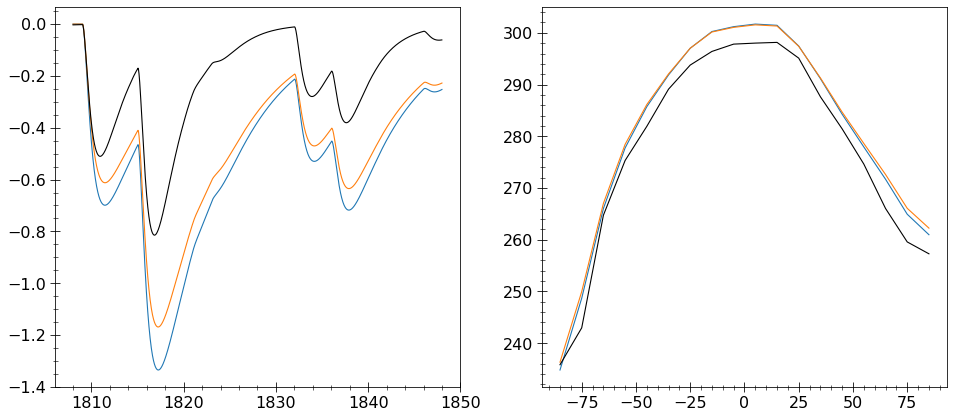

In [36]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
ax[0].plot(data[0]/constants.time_sec_year,data[2]-data[2][0])
ax[0].plot(data1[0]/constants.time_sec_year,data1[2]-data1[2][0])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')

elevation=-0.0065*np.array(ParasCTRL[1][1])
ax[1].plot(Vars.Lat,data[1][0]+elevation)
ax[1].plot(Vars.Lat,data1[1][0]+elevation)
ax[1].plot(Lat_10,ZMT_10,c='k')

plt.savefig('Coupled_Optimization.eps',format='EPS')

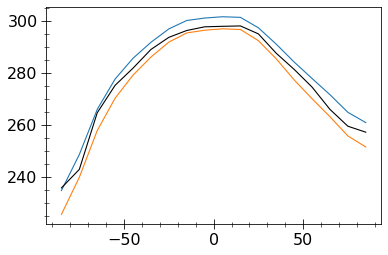

In [25]:
elevation=-0.0065*np.array(ParasCTRL[1][1])
plt.plot(Vars.Lat,data[1][0]+elevation)
plt.plot(Vars.Lat,data1[1][0]+elevation)
plt.plot(Lat_10,ZMT_10,c='k')